# What drives the price of a car?


**OVERVIEW**

In this application, I explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  My goal is to understand what factors make a car more or less expensive, so that I may provide clear recommendations to my client -- a used car dealership -- as to what consumers value in a used car.

## Business Understanding
The business goal, is to provide recommendations to a used car dealership as to what customers value in a used car. Put in technical terms, the task is to identify features that best contribute to the price of used cars. I shall attempt to use:

1. Feature importance using Ridge Regression with appropriate regularization parameter, and
2. Feature importance using Linear Regression

to achieve this objective.


## Data Cleaning


In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = pd.read_csv("data/vehicles.csv")
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

We assume `region`s are defined within `state` boundaries, and since `region`s are finer, we may safely drop the `state` column. 

The columns `id` and `VIN` may also be left out.

For cars with the same `manufacturer` and class (e.g. sedan) the price of the car goes up along size. However the `size` column has < 30% of non-null values, and there is no clear way to impute, so we choose to drop that column as well.




In [3]:
df = df0.drop(['id', 'VIN', 'size', 'state'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


### Categorical Columns

The data has serious quality issues in that many columns are still missing more than 40% of observations.

For `year`, `manufacturer`, `model`, `fuel`, `odometer`, `title_status`, `transmission`, the null value count combined is < 10% of all observations, so we drop those rows.

Subsequently we use the value `unknown` to for missing values in categorical data, and drop duplicate rows that are results of this assignment.


In [4]:
df = df.dropna(subset=['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'])
df = df.fillna('unknown')
df = df.drop_duplicates()

### Numerical Columns
The columns `price` and `odometer` have many outliers. I use the interquartile range to remove their outliers. 

<Axes: ylabel='odometer'>

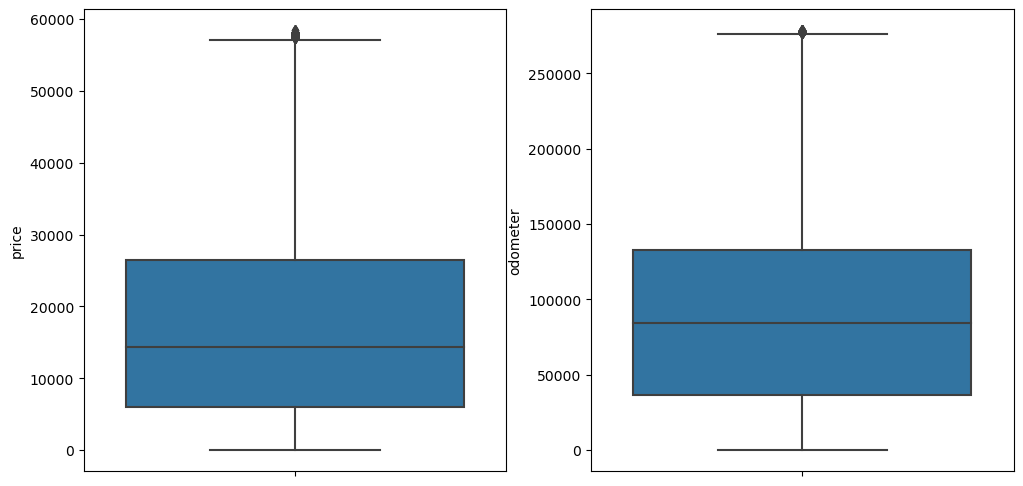

In [5]:

q25, q75 = np.quantile(df['price'], [0.25, 0.75]) 
iqr = q75-q25
lb1, ub1 = q25- 1.5*iqr, q75+ 1.5*iqr

q25, q75 = np.quantile(df['odometer'], [0.25, 0.75]) 
iqr = q75-q25
lb2, ub2 = q25- 1.5*iqr, q75+ 1.5*iqr

df = df.query(f'price >= {lb1} and price <= {ub1} and odometer >= {lb2} and odometer <= {ub2}')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(ax=axes[0], data=df, y='price')
sns.boxplot(ax=axes[1], data=df, y='odometer')

At first glance price doesn't seem to be correlated with year or odometer. 

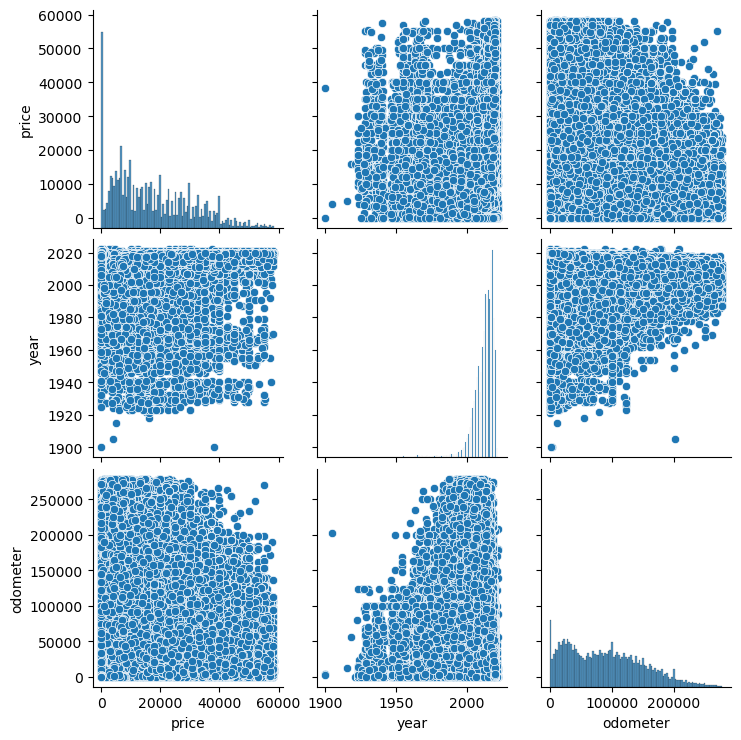

In [6]:
sns.pairplot(data=df)

### Categorical Columns revisited

There are too many `region`, `manufacturer`, and in particular `model` categorical values:

In [7]:
for c in df.select_dtypes(exclude=np.number).columns:
    print('{}: {}'.format(c, df[c].value_counts().count()))

region: 404
manufacturer: 41
model: 21106
condition: 7
cylinders: 9
fuel: 5
title_status: 6
transmission: 3
drive: 4
type: 14
paint_color: 13


In [8]:
def pareto_count(df, colname, thres=0.8):
    '''
    Returns the number of values needed to execeed at least thres % of the total observations
    '''
    values = df[colname].value_counts()
    cum=np.cumsum(values)
    nvals = np.sum(np.where(cum > thres * df.shape[0], 0, 1)) + 1
    return nvals


The kernel kept on dying when I tried to use categorical values that cover 80% of the observed values (the Pareto rule). Out of necessity I chose categorical values that cover 70% (or 119 values) for `region`, and values that cover 40% (or 130 values) for `model`. I assigned the value 'other' to the remainder.

In [9]:
man_count = pareto_count(df, 'manufacturer', 0.9)
reg_count = pareto_count(df, 'region', 0.7)
mod_count = pareto_count(df, 'model', 0.4)

print(df['region'].value_counts()[:reg_count])
print(df['model'].value_counts()[:mod_count])


minneapolis / st paul    2688
sacramento               2615
portland                 2585
denver                   2585
SF bay area              2574
                         ... 
lexington                 985
missoula                  980
kalamazoo                 964
fredericksburg            963
roanoke                   954
Name: region, Length: 122, dtype: int64
f-150                        6241
silverado 1500               4080
1500                         3280
camry                        2466
accord                       2420
                             ... 
silverado 1500 lt             367
ranger supercab xl pickup     366
g6                            365
q5                            363
beetle                        362
Name: model, Length: 144, dtype: int64


In [10]:
def binify_category(df, colname, val_count, other_str="other"):
    vals = df[colname].value_counts()[:val_count]
    newvals=[]
    for k in range(df[colname].shape[0]):
        if df[colname].iloc[k] in vals:
            newvals.append(df[colname].iloc[k])
        else:
            newvals.append(other_str)
    df[colname] = newvals

binify_category(df, 'manufacturer', man_count)
binify_category(df, 'region', reg_count)
binify_category(df, 'model', mod_count)


Below are some exploratory plots. Initially I considered using OridinalEncoder for `condition`. However it wasn't clear how I should order the value 'unknown'. It isn't clear how to order 'excellent' and 'like new' either. Thus for all categorical columns I chose to use one hot encoding.

<Axes: xlabel='condition', ylabel='price'>

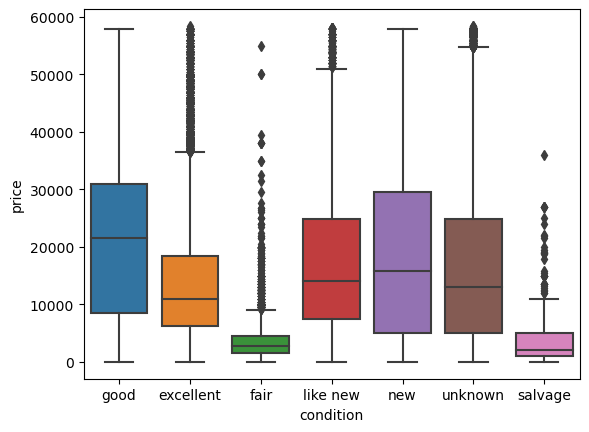

In [11]:
sns.boxplot(data=df, x='condition', y='price')

<Axes: xlabel='fuel', ylabel='price'>

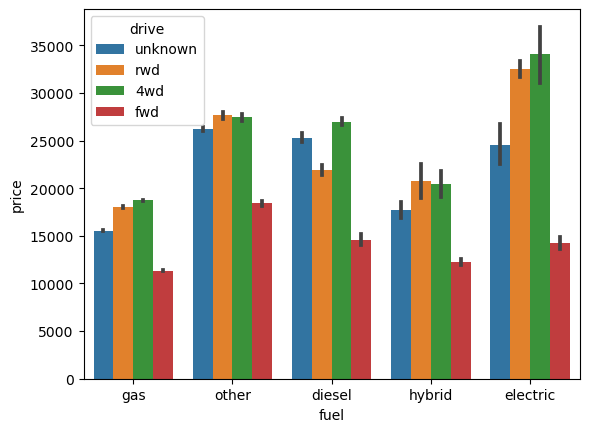

In [12]:
sns.barplot(data=df, x='fuel',y='price', hue='drive')

Text(0.5, 1.0, 'manufacturer vs price')

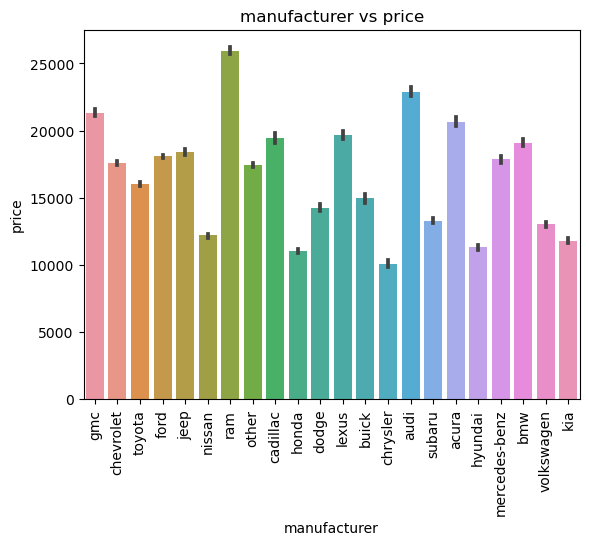

In [13]:
sns.barplot(data=df, x='manufacturer',y='price')
plt.xticks(rotation=90)
plt.title('manufacturer vs price')

Text(0.5, 1.0, 'type vs price')

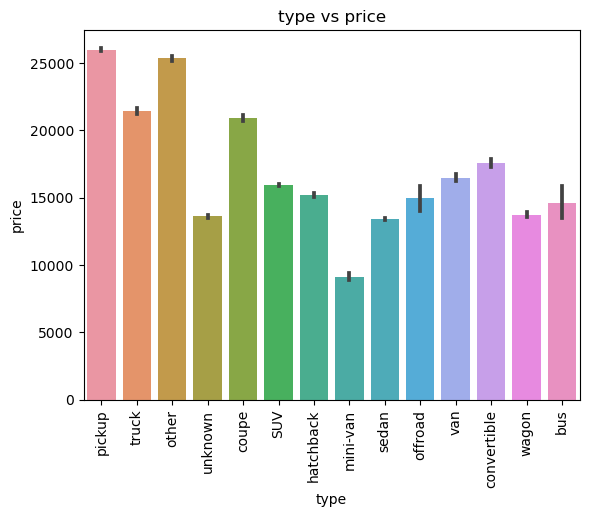

In [14]:
sns.barplot(data=df, x='type',y='price')
plt.xticks(rotation=90)
plt.title('type vs price')

## Feature importance using Ridge Regression

In [15]:
df1=df.copy()
df1.reset_index(inplace=True)
df1.drop(['index'], axis=1, inplace=True)
df1

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
0,other,33590,2014.0,gmc,other,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white
1,other,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue
2,other,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red
3,other,30990,2017.0,toyota,other,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red
4,other,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330205,other,23590,2019.0,nissan,other,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown
330206,other,30590,2020.0,other,other,good,unknown,gas,12029.0,clean,other,fwd,sedan,red
330207,other,34990,2020.0,cadillac,xt4 sport suv 4d,good,unknown,diesel,4174.0,clean,other,unknown,hatchback,white
330208,other,28990,2018.0,lexus,other,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver


Train/test split 0.7:0.3.

In [16]:
seed=12
X_train, X_test, y_train, y_test = train_test_split(df1.drop(['price'], axis = 1), df1['price'], random_state = seed, test_size =0.3)
X_train.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
287267,dallas / fort worth,2012.0,nissan,altima,like new,6 cylinders,gas,162000.0,rebuilt,automatic,fwd,sedan,black
223650,akron / canton,2010.0,subaru,forester,unknown,unknown,gas,177712.0,clean,automatic,unknown,SUV,green
32296,orange county,1992.0,bmw,other,excellent,4 cylinders,gas,59849.0,clean,manual,unknown,unknown,unknown
274106,other,2017.0,subaru,other,unknown,unknown,gas,24104.0,rebuilt,automatic,unknown,unknown,unknown
206019,other,2017.0,ram,other,good,unknown,other,41816.0,clean,other,4wd,pickup,unknown


Setting up column transformers for the one hot encoding and scaling of continuous columns. Checking whether the transformers are working ok.

In [17]:
pipe_cat = Pipeline([ ('ohe', OneHotEncoder(sparse=False)) ])
pipe_num = Pipeline([ ('scaler', StandardScaler()) ])
ct = ColumnTransformer([
    ('ct_cat', pipe_cat['ohe'], \
     ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']),
    ('ct_num', pipe_num, ['odometer', 'year'])
    ], verbose_feature_names_out=False)

X_test_ct_test = ct.fit_transform(X_test) # this variable to check if the transformers are working
X_test_ct_test = pd.DataFrame(X_test_ct_test, columns=ct.get_feature_names_out()) 


Setting up Ridge Regression. In particular I am using 5-fold cross-validation along the grid search for the optimal hyperparameter $\alpha$.

In [18]:

pipe= Pipeline([
    ('column_transformer', ct),
    ('ridge', Ridge())
])

param_dict = {'ridge__alpha': [1.0, 2.5, 5.0, 7.5, 10.0]}
grid = GridSearchCV(pipe, param_grid=param_dict, cv=5)


rs = grid.fit(X_train, y_train) # r[esult]s[et]
y_pred = rs.predict(X_test)

print('MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.4f}'.format(mean_absolute_error(y_test, y_pred)))

MSE: 85891041.9629
MAE: 6533.1537


In [19]:
ct_cols = ct.get_feature_names_out()

estim=rs.best_estimator_.named_steps['ridge']
coef=estim.coef_

print(rs.best_estimator_)


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('ct_cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['region', 'manufacturer',
                                                   'model', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color']),
                                                 ('ct_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer', 'year'])],
                                   verbose_feature_names_out=False)),
            

Below are the top 20 features predicted by the ridge regressor. The top results are dominated by particular car models.

Text(0.5, 1.0, 'Top 20 Expanded Features Importance using Ridge Regression')

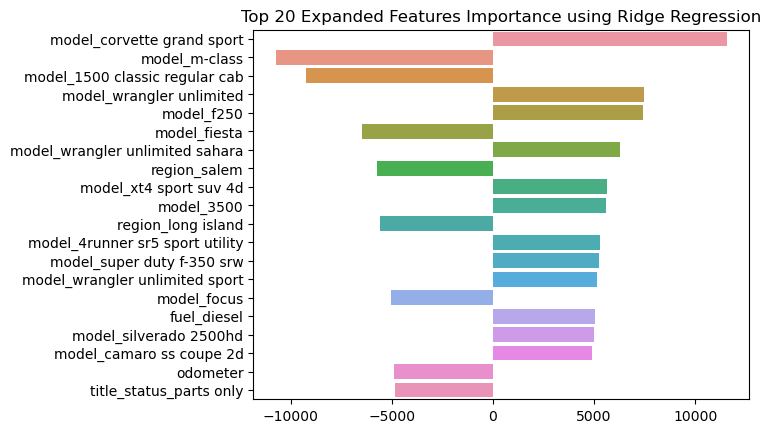

In [20]:
sorted_idx=np.abs(coef).argsort()[::-1]

topn=20
sns.barplot(x=coef[sorted_idx][:topn], y=ct_cols[sorted_idx][:topn])
plt.title(f'Top {topn} Expanded Features Importance using Ridge Regression')

Evidently we seek the importance of the original features. We provide the answer using scikit-learn's permutation_importance. Odometer, year, and make/model appear to be of most detrimental to the price. As the earlier pair plot showed, the lower the odometer, the higher the price, and the newer the car is the higher its price.

Text(0.5, 1.0, 'Original Features Importance using Ridge Regression')

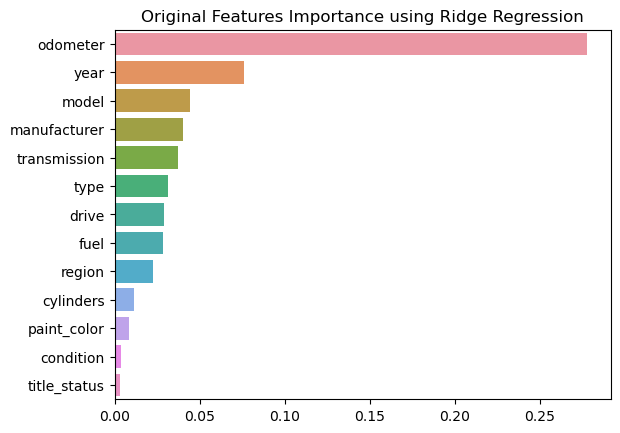

In [21]:
pi = permutation_importance(rs.best_estimator_, X_test, y_test, random_state=seed) 
sorted_idx = pi.importances_mean.argsort()[::-1]
sns.barplot(x=pi.importances_mean[sorted_idx], y=X_test.columns[sorted_idx])
plt.title('Original Features Importance using Ridge Regression')

## Feature importance with Linear Regression

We employ a similar strategy to determine feature importance - we use in linear regressor insteaf of a ridge regressor here and compare the magnitude of the coefficients.

In [22]:
pipe_linreg = Pipeline([
    ('column_transformer', ct),
    ('linreg', LinearRegression())
])


rs_linreg = pipe_linreg.fit(X_train, y_train)
y_pred = rs_linreg.predict(X_test)

print('MSE: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.4f}'.format(mean_absolute_error(y_test, y_pred)))


MSE: 85896540.6007
MAE: 6532.9684


Text(0.5, 1.0, 'Top 20 Expanded Features Importance using Linear Regression')

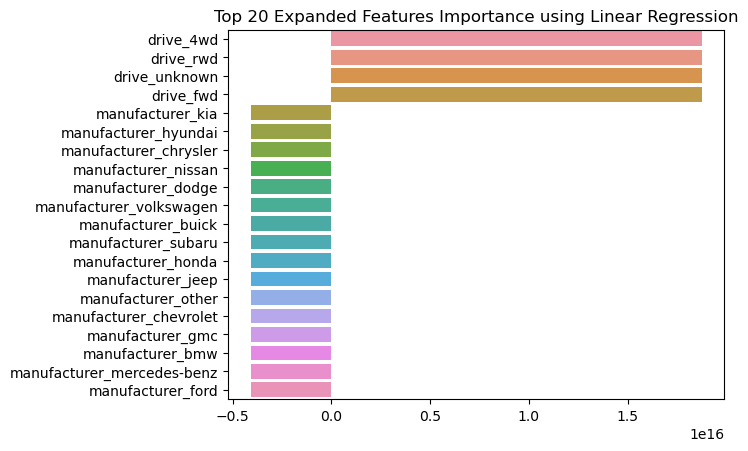

In [23]:
coef=rs_linreg.named_steps['linreg'].coef_
sorted_idx=np.abs(coef).argsort()[::-1]

topn=20
sns.barplot(x=coef[sorted_idx][:topn], y=ct_cols[sorted_idx][:topn])
plt.title(f'Top {topn} Expanded Features Importance using Linear Regression')



Text(0.5, 1.0, 'Original Features Importance using Linear Regression')

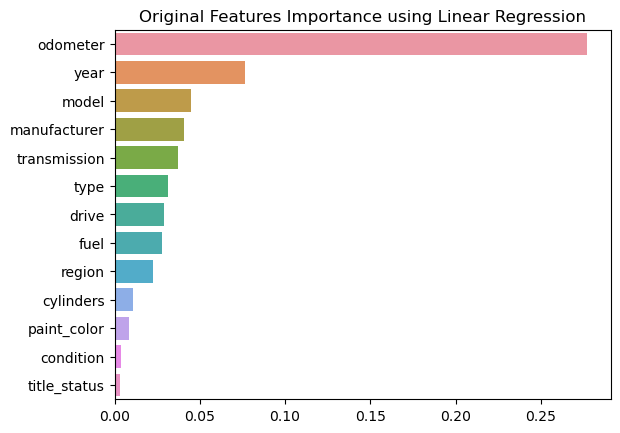

In [24]:
pi_linreg = permutation_importance(rs_linreg, X_test, y_test, random_state=seed) 
sorted_idx = pi_linreg.importances_mean.argsort()[::-1]
sns.barplot(x=pi_linreg.importances_mean[sorted_idx], y=X_test.columns[sorted_idx])
plt.title('Original Features Importance using Linear Regression')

# Recommendations

The quality of the fits for the Ridge and Linear regressors are almost identical as evidenced by the respective mean square and mean absolute errors. The orignal features importance they produce are identical in order too. Thus the recommendation to dealerships would be to, assuming all other features equal:
1. stock cars with lower mileage,
2. stock newer cars,
3. identify pricier make/models to stock

# Next Steps
1. As noted earlier, there are serious quality issues with the data. For instance we should seek a data set that contains mostly non-null `size` for a better analysis.
2. Due to hardware constraints we weren't able to take into account the vast majorities of `model` and `region` values. Better hardware clearly shall produce more accurate results.
3. We've only made use of two similar regressors. Other ML algorithms should be included.
4. Better parameter optimization (in our case the hyperparameter $\alpha$ for ridge regression) theoretically shall produce more accurate results.
